In [68]:
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from glob import glob

In [69]:
COLOR_TRAIN_DIR = "data/train_color"
BLACK_TRAIN_DIR = "data/train_black"
COLOR_TEST_DIR = "data/test_color"
BLACK_TEST_DIR = "data/test_black2"
IMG_SIZE = 64 #images are 400x400 ---- Make them smaller to use less memory but keep accuracy
BATCH_SIZE = 50 # hyperparameter we need to optimize
EPOCHS = 20
NUMBER_OF_IMAGES = 100
DEVICE = torch.device("cpu") #running on my macbook without a gpu ---- CAN ADD GPU SUPPPORT FOR OTHER DEVICES

## Step 1 is to create a class that can hold our loaded datasets, as well as process the images in our dataset for the model

In [70]:
class ColorizationDataset(Dataset):
    # Built in double underscore python method to be the classe's constructor
    def __init__(self, colorPaths, grayscalePaths, imageSize):
        # This will define all images to class variables that are passed in the paths. i.e. "data/train_color" for self.colorpaths
        self.colorPaths = sorted(glob(os.path.join(colorPaths, '*.jpg')))[:NUMBER_OF_IMAGES]
        self.grayscalePaths = sorted(glob(os.path.join(grayscalePaths, '*.jpg')))[:NUMBER_OF_IMAGES]
        self.imageSize = imageSize

    # Built in double underscore python method to get length of data that our class instance holds
    def __len__(self):
        return len(self.grayscalePaths)
    
    # Function to process colored and grayscale images into L channel, and ab channels foro the LAB color spaces in this model
    def processImages(self, colorImagePath, grayscaleImagePath):
        # Read our images and then resize them to the image size which should generally be a smaller size than original to conserve memory when processing
        grayscaleImage = cv2.imread(grayscaleImagePath, cv2.IMREAD_GRAYSCALE)
        colorImage = cv2.imread(colorImagePath)
        grayscaleImage = cv2.resize(grayscaleImage, (self.imageSize, self.imageSize))
        colorImage = cv2.resize(colorImage, (self.imageSize, self.imageSize))

        # Defines LAB color space by using Opencv functions to take a colored image and put in into Lab
        labColorSpace = cv2.cvtColor(colorImage, cv2.COLOR_BGR2Lab)

        # Regularizes the L grayscale strength values to be within 0-1 (255 is common practice in machine learning world)
        L = grayscaleImage / 255.0


        # Gets the chrominance of a and b channels by making all values within the range [-1,1] (Commonly used in neural networks)
        a = (labColorSpace[:,:,1] - 128) / 128.0 
        b = (labColorSpace[:,:,2] - 128) / 128.0 

        # Converts to tensor (Multidimensional array for high-performance computation with CPU and GPUs)
        L = torch.tensor(L, dtype=torch.float32).unsqueeze(0)
        # Using stack to speed-up performance by joining a and b channels stacked on the 0 axis (All of a stacked on all of b)
        ab = torch.tensor(np.stack([a,b], axis=0), dtype=torch.float32)
        

        return L, ab

    # Built in double underscore python method to get the index of the item in our class instance.
    def __getitem__(self, idx):
        grayscaleImagePath = self.grayscalePaths[idx]
        colorImagePath = self.colorPaths[idx]
        L, ab = self.processImages(colorImagePath, grayscaleImagePath)
        return L, ab



        

In [71]:
class ColorizationModelNeuralNetwork(nn.Module):
    # Class construction using same built in python double underscore method
    def __init__(self):
        super(ColorizationModelNeuralNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(), # USING THE RELU ACTIVATION FUNCTION LIKE WE SAW IN CLASS
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=(3,3), padding=1),
            nn.Tanh()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [72]:
# This will put our images into a class dataset so we can load and process the images before training the model
train_dataset = ColorizationDataset(COLOR_TRAIN_DIR, BLACK_TRAIN_DIR, IMG_SIZE)
test_dataset = ColorizationDataset(COLOR_TEST_DIR, BLACK_TEST_DIR, IMG_SIZE)

# Loads the data correctly in a certain batch size to help with the EPOCH's in our training process.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Now we want to initialize the model, the mean squared error loss criterion, and the optimizer for our model

In [73]:
colorizerModel = ColorizationModelNeuralNetwork().to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(colorizerModel.parameters(), lr=1e-4)

## Now Load Our Image Dataset we chose and Train the Model

In [74]:
for epoch in range(EPOCHS):
    colorizerModel.train()
    running_loss = 0.0
    for L, ab in train_loader:
        L, ab = L.to(DEVICE), ab.to(DEVICE)

        optimizer.zero_grad()

        ab_prediction = colorizerModel(L)
        loss = criterion(ab_prediction, ab)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/20, Loss: 0.7285
Epoch 2/20, Loss: 0.7127
Epoch 3/20, Loss: 0.7014
Epoch 4/20, Loss: 0.6915
Epoch 5/20, Loss: 0.6830
Epoch 6/20, Loss: 0.6810
Epoch 7/20, Loss: 0.6836
Epoch 8/20, Loss: 0.6846
Epoch 9/20, Loss: 0.6832
Epoch 10/20, Loss: 0.6806
Epoch 11/20, Loss: 0.6800
Epoch 12/20, Loss: 0.6803
Epoch 13/20, Loss: 0.6806
Epoch 14/20, Loss: 0.6807
Epoch 15/20, Loss: 0.6800
Epoch 16/20, Loss: 0.6796
Epoch 17/20, Loss: 0.6792
Epoch 18/20, Loss: 0.6791
Epoch 19/20, Loss: 0.6791
Epoch 20/20, Loss: 0.6788


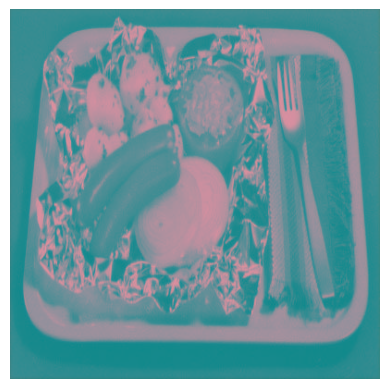

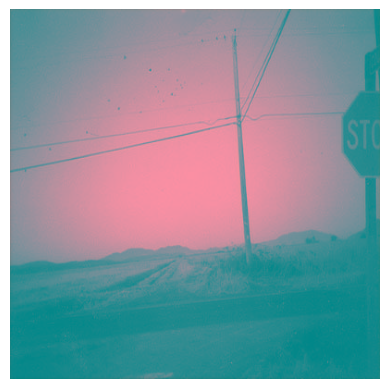

In [75]:
def colorizeImage(model, imagePath):
    L_image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    L = L_image / 255.0

    L_tensor = torch.tensor(L, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    L_tensor = L_tensor.to(DEVICE)

    with torch.no_grad():
        ab_prediction = model(L_tensor).cpu()

    ab_prediction = ab_prediction.squeeze().numpy()
    
    # Un-regularizes the values that were between [-1,1]
    a = ab_prediction[0] * 128 + 128
    b = ab_prediction[1] * 128 + 128

    
    L_image = (L * 255).astype(np.uint8)

    colorized_lab = np.stack([L_image, a.astype(np.uint8), b.astype(np.uint8)], axis=-1)
    colorized_bgr = cv2.cvtColor(colorized_lab, cv2.COLOR_BGR2RGB)

    plt.imshow(cv2.cvtColor(colorized_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def colorizeTestSet(model, imageSetPath):
    for image in os.listdir(imageSetPath):
        if image.endswith('.jpg'):
            grayscalePath = os.path.join(imageSetPath, image)
            colorizeImage(model, grayscalePath)

colorizeTestSet(colorizerModel, BLACK_TEST_DIR)